# Error Analysis Across All Models

Segmented error analysis comparing XGBoost, LightGBM, LSTM, and TCN across routes, seasons, and day types.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import torch
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

from src.models.lstm import FlightDelayLSTM
from src.models.tcn import FlightDelayTCN
from src.evaluation.error_analysis import ErrorAnalyzer
from src.evaluation.metrics import calculate_delay_metrics
from src.config import TRAIN_END, VAL_END, TEST_START
from src.config import SEQUENCE_MODEL_FEATURES, TABULAR_FEATURES

os.makedirs('../outputs', exist_ok=True)

TARGET_COL = 'avg_arr_delay'
device = torch.device('mps')
MODEL_NAMES = ['XGBoost', 'LightGBM', 'LSTM', 'TCN']

Importing plotly failed. Interactive plots will not work.


## Load Data and Model

In [2]:
# load feature data
df = pd.read_csv('../data/processed/features.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['route', 'date']).reset_index(drop=True)

available_features = [c for c in SEQUENCE_MODEL_FEATURES if c in df.columns]
print(f'Features: {len(available_features)} (minimal time-native set for LSTM)')

Features: 22 (minimal time-native set for LSTM)


In [3]:
# create train/val/test splits and prepare test sequences
sequence_length = 28

train_df = df[df['date'] < TRAIN_END].copy()
val_df = df[(df['date'] >= TRAIN_END) & (df['date'] < VAL_END)].copy()
test_df = df[df['date'] >= TEST_START].copy()

print(f'Train: {len(train_df):,} ({train_df["date"].min().date()} to {train_df["date"].max().date()})')
print(f'Val:   {len(val_df):,} ({val_df["date"].min().date()} to {val_df["date"].max().date()})')
print(f'Test:  {len(test_df):,} ({test_df["date"].min().date()} to {test_df["date"].max().date()})')

scaler = StandardScaler()
scaler.fit(train_df[available_features].values)

def create_route_sequences(route_df, scaler, feature_cols, target_col, seq_len):
    """Create sequences per route for proper time series handling (matches LSTM/TCN training)."""
    all_X, all_y, all_meta = [], [], []
    for route in route_df['route'].unique():
        rdf = route_df[route_df['route'] == route].sort_values('date')
        features = scaler.transform(rdf[feature_cols].values)
        targets = rdf[target_col].values
        dates = rdf['date'].values
        for i in range(seq_len, len(rdf)):
            all_X.append(features[i-seq_len:i])
            all_y.append(targets[i])
            all_meta.append({'route': route, 'date': dates[i]})
    return np.array(all_X), np.array(all_y), all_meta

test_X, test_y, test_meta = create_route_sequences(test_df, scaler, available_features, TARGET_COL, sequence_length)

test_dataset = TensorDataset(
    torch.tensor(test_X, dtype=torch.float32),
    torch.tensor(test_y, dtype=torch.float32)
)
test_loader = DataLoader(test_dataset, batch_size=32)

test_df_aligned = pd.DataFrame(test_meta)
test_df_aligned[TARGET_COL] = test_y
print(f'Test samples (after sequencing): {len(test_y):,}')

Train: 36,520 (2019-01-01 to 2023-12-31)
Val:   3,640 (2024-01-01 to 2024-06-30)
Test:  7,300 (2024-07-01 to 2025-06-30)
Test samples (after sequencing): 6,740


In [4]:
# load all four trained models
models = {}

lstm = FlightDelayLSTM(input_size=len(available_features), hidden_size=64, num_layers=2)
lstm_ckpt = torch.load('../trained_models/best_lstm_arr_delay.pt', map_location=device, weights_only=False)
lstm.load_state_dict(lstm_ckpt['model_state_dict'])
lstm.to(device)
lstm.eval()
models['LSTM'] = lstm

tcn = FlightDelayTCN(input_size=len(available_features), num_channels=[32, 64, 64], kernel_size=3)
tcn_ckpt = torch.load('../trained_models/best_tcn_arr_delay.pt', map_location=device, weights_only=False)
tcn.load_state_dict(tcn_ckpt['model_state_dict'])
tcn.to(device)
tcn.eval()
models['TCN'] = tcn

models['XGBoost'] = joblib.load('../trained_models/xgboost_delay.pkl')
models['LightGBM'] = joblib.load('../trained_models/lightgbm_delay.pkl')

xgb_features = joblib.load('../trained_models/xgboost_features.pkl')
lgb_features = joblib.load('../trained_models/lightgbm_features.pkl')

print(f'Loaded models: {list(models.keys())}')
print(f'XGBoost features: {len(xgb_features)}, LightGBM features: {len(lgb_features)}')

Loaded models: ['LSTM', 'TCN', 'XGBoost', 'LightGBM']
XGBoost features: 57, LightGBM features: 57


## Generate Predictions

In [5]:
# generate predictions for all four models
all_predictions = {}

# LSTM predictions from sequence data
def predict_sequences(model, loader):
    """Run inference on sequence data using a PyTorch model."""
    model.eval()
    preds = []
    with torch.no_grad():
        for x_batch, _ in loader:
            x_batch = x_batch.to(device)
            preds.extend(model(x_batch).cpu().numpy())
    return np.array(preds)

all_predictions['LSTM'] = predict_sequences(models['LSTM'], test_loader)
all_predictions['TCN'] = predict_sequences(models['TCN'], test_loader)

# tabular model predictions need to be aligned to the same dates as sequences
# build a lookup from (route, date) to row index in test_df
test_df_lookup = test_df.copy()
test_df_lookup['_idx'] = range(len(test_df_lookup))
test_df_lookup = test_df_lookup.set_index(['route', 'date'])

aligned_indices = []
for meta in test_meta:
    route = meta['route']
    date = pd.Timestamp(meta['date'])
    aligned_indices.append(test_df_lookup.loc[(route, date), '_idx'])

tabular_aligned = test_df.iloc[aligned_indices]

# pass DataFrames (not .values) so sklearn doesn't warn about missing feature names
all_predictions['XGBoost'] = models['XGBoost'].predict(tabular_aligned[xgb_features])
all_predictions['LightGBM'] = models['LightGBM'].predict(tabular_aligned[lgb_features])

actuals = test_y

for name, preds in all_predictions.items():
    print(f'{name}: {len(preds)} predictions')

LSTM: 6740 predictions
TCN: 6740 predictions
XGBoost: 6740 predictions
LightGBM: 6740 predictions


## Overall Metrics

In [6]:
# overall metrics comparison across all models
rows = []
for name in MODEL_NAMES:
    metrics = calculate_delay_metrics(actuals, all_predictions[name])
    metrics['model'] = name
    rows.append(metrics)

metrics_df = pd.DataFrame(rows).set_index('model')
display_cols = ['mae', 'rmse', 'r2', 'mape', 'within_15']
print('Overall Test Metrics (all models):')
metrics_df[display_cols].round(3)

Overall Test Metrics (all models):


,mae,rmse,r2,mape,within_15
model,,,,,
XGBoost,11.433,19.069,0.357,121.908,78.309
LightGBM,11.430,19.205,0.348,119.352,78.383
LSTM,13.957,22.521,0.103,143.876,70.371
TCN,13.633,21.689,0.168,152.836,70.148


## Error Analysis by Segment

In [7]:
# build an ErrorAnalyzer per model for segmented breakdowns
analyzers = {}
for name in MODEL_NAMES:
    analyzers[name] = ErrorAnalyzer(test_df_aligned, actuals, all_predictions[name])

# metrics by route for each model
print('METRICS BY ROUTE')
for name in MODEL_NAMES:
    print(f'\n{name}:')
    route_metrics = analyzers[name].metrics_by_route()
    print(route_metrics[['rmse', 'mae', 'mape']].round(2).to_string())

METRICS BY ROUTE

XGBoost:
          rmse    mae    mape
route                        
ATL-FLL  28.37  14.12  138.32
ATL-MCO  24.84  13.69  138.62
BOS-DCA  21.29  13.02  116.61
DCA-BOS  20.20  13.54  119.53
DEN-LAS  18.30  11.65  119.11
DEN-PHX  14.78  10.12  114.32
FLL-ATL  25.47  14.96  145.86
HNL-OGG   6.73   3.91  116.61
JFK-LAX  18.41  13.61  106.86
LAS-DEN  16.72  11.52  120.38
LAS-LAX  12.97   9.26  113.70
LAX-JFK  19.70  14.72  121.74
LAX-LAS  14.52   9.32  110.53
LAX-SFO  16.37  10.18  111.02
LGA-ORD  24.46  14.68  130.29
MCO-ATL  23.90  13.05  140.71
OGG-HNL   7.24   4.67  113.66
ORD-LGA  20.77  13.51  128.36
PHX-DEN  15.17  10.17  126.42
SFO-LAX  14.32   8.97  104.96

LightGBM:
          rmse    mae    mape
route                        
ATL-FLL  28.77  14.07  144.61
ATL-MCO  25.48  13.51  135.43
BOS-DCA  20.65  13.05  113.94
DCA-BOS  20.74  13.67  114.93
DEN-LAS  18.67  11.78  122.41
DEN-PHX  14.95  10.40  116.76
FLL-ATL  25.64  15.09  141.45
HNL-OGG   6.36   3.80  107.86
JF

In [8]:
# metrics by time period for each model
print('METRICS BY TIME PERIOD')
for name in MODEL_NAMES:
    print(f'\n{name}:')
    period_metrics = analyzers[name].metrics_by_time_period()
    print(period_metrics[['rmse', 'mae', 'mape']].round(2).to_string())

METRICS BY TIME PERIOD

XGBoost:
             rmse    mae    mape
Post-COVID  19.07  11.43  121.91

LightGBM:
            rmse    mae    mape
Post-COVID  19.2  11.43  119.35

LSTM:
             rmse    mae    mape
Post-COVID  22.52  13.96  143.88

TCN:
             rmse    mae    mape
Post-COVID  21.69  13.63  152.84


In [9]:
# metrics by day type for each model
print('METRICS BY DAY TYPE')
for name in MODEL_NAMES:
    print(f'\n{name}:')
    day_metrics = analyzers[name].metrics_by_day_type()
    print(day_metrics[['rmse', 'mae', 'mape']].round(2).to_string())

METRICS BY DAY TYPE

XGBoost:
          rmse    mae    mape
Weekday  19.31  11.34  120.11
Weekend  18.46  11.66  126.37

LightGBM:
          rmse    mae    mape
Weekday  19.39  11.29  117.42
Weekend  18.72  11.78  124.15

LSTM:
          rmse    mae    mape
Weekday  22.59  13.78  139.63
Weekend  22.34  14.40  154.43

TCN:
          rmse    mae    mape
Weekday  21.93  13.54  149.73
Weekend  21.07  13.87  160.56


In [10]:
# metrics by season for each model
print('METRICS BY SEASON')
for name in MODEL_NAMES:
    print(f'\n{name}:')
    season_metrics = analyzers[name].metrics_by_season()
    print(season_metrics[['rmse', 'mae', 'mape']].round(2).to_string())

METRICS BY SEASON

XGBoost:
              rmse    mae    mape
Q1 (Winter)  23.18  12.47  114.36
Q2 (Spring)  20.79  13.36  134.59
Q3 (Summer)  17.27  11.08  133.18
Q4 (Fall)    13.09   8.76  108.94

LightGBM:
              rmse    mae    mape
Q1 (Winter)  23.38  12.51  111.59
Q2 (Spring)  21.09  13.36  129.47
Q3 (Summer)  17.17  11.07  133.90
Q4 (Fall)    13.08   8.72  106.86

LSTM:
              rmse    mae    mape
Q1 (Winter)  28.16  16.27  141.51
Q2 (Spring)  23.41  14.81  135.06
Q3 (Summer)  20.53  13.27  150.83
Q4 (Fall)    15.72  11.32  150.10

TCN:
              rmse    mae    mape
Q1 (Winter)  27.17  15.71  146.87
Q2 (Spring)  22.96  15.69  179.14
Q3 (Summer)  19.28  12.63  158.78
Q4 (Fall)    14.87  10.26  128.53


## Model Comparison Visualizations

Comparing all four models across overall performance, seasonal patterns, route-level breakdown, and error distributions.

In [11]:
import seaborn as sns

# blue = tree-based, red/orange = deep learning
MODEL_COLORS = {
    'XGBoost':  'steelblue',
    'LightGBM': 'lightskyblue',
    'TCN':      'crimson',
    'LSTM':     'sandybrown',
}
TREE_MODELS = ['XGBoost', 'LightGBM']
DL_MODELS = ['LSTM', 'TCN']
SEASONS = ['Q1 (Winter)', 'Q2 (Spring)', 'Q3 (Summer)', 'Q4 (Fall)']

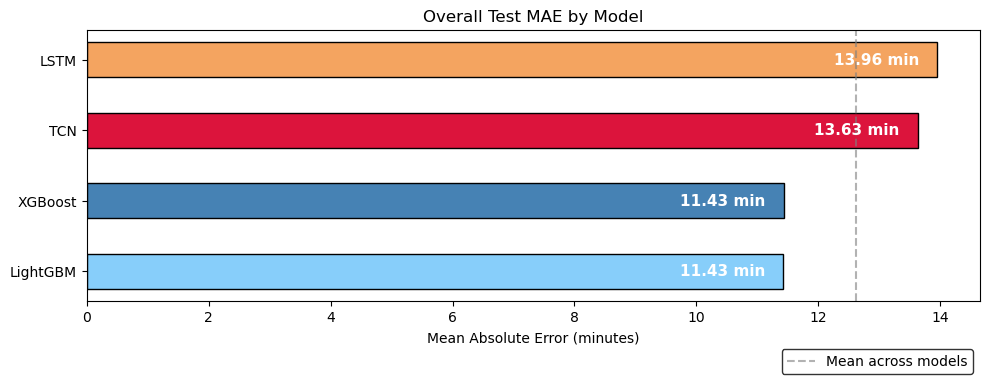

In [12]:
# overall MAE comparison
fig, ax = plt.subplots(figsize=(10, 4))

mae_vals = {name: np.mean(np.abs(all_predictions[name] - actuals)) for name in MODEL_NAMES}
sorted_names = sorted(mae_vals, key=mae_vals.get)

bars = ax.barh(sorted_names, [mae_vals[m] for m in sorted_names],
               color=[MODEL_COLORS[m] for m in sorted_names],
               edgecolor='black', height=0.5)

for bar, name in zip(bars, sorted_names):
    ax.text(bar.get_width() - 0.3, bar.get_y() + bar.get_height()/2,
            f'{mae_vals[name]:.2f} min', va='center', ha='right', fontsize=11,
            color='white', fontweight='bold')

avg_mae = np.mean(list(mae_vals.values()))
ax.axvline(avg_mae, color='gray', linestyle='--', alpha=0.6, label='Mean across models')

ax.set_xlabel('Mean Absolute Error (minutes)')
ax.set_title('Overall Test MAE by Model')
ax.legend(frameon=True, edgecolor='black', loc='upper right',
          bbox_to_anchor=(1.0, -0.15), ncol=1)
plt.tight_layout()
plt.show()

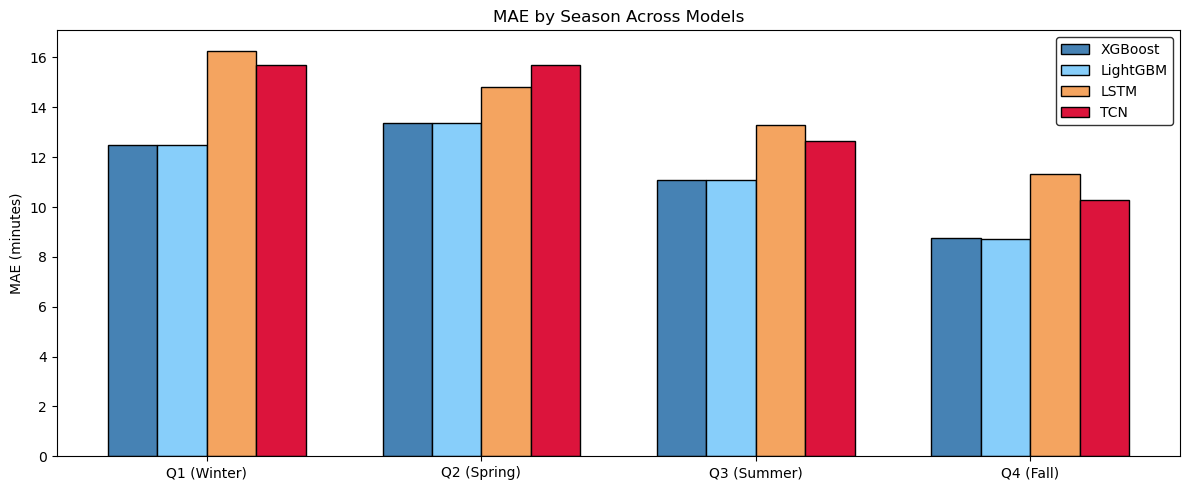

In [13]:
# MAE by season, grouped by model
season_mae = {}
for name in MODEL_NAMES:
    season_mae[name] = analyzers[name].metrics_by_season()['mae']

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(SEASONS))
width = 0.18

for i, name in enumerate(MODEL_NAMES):
    offset = (i - 1.5) * width
    vals = [season_mae[name].loc[s] for s in SEASONS]
    ax.bar(x + offset, vals, width, label=name,
           color=MODEL_COLORS[name], edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(SEASONS)
ax.set_ylabel('MAE (minutes)')
ax.set_title('MAE by Season Across Models')
ax.legend(frameon=True, edgecolor='black')
plt.tight_layout()
plt.show()

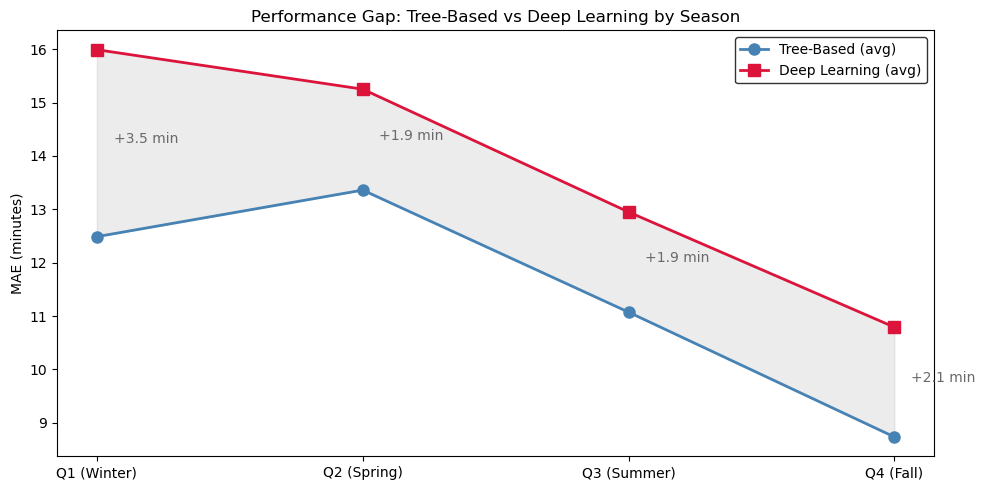

In [14]:
# zooming in on the gap between tree-based and deep learning by season
tree_avg = [np.mean([season_mae[m].loc[s] for m in TREE_MODELS]) for s in SEASONS]
dl_avg = [np.mean([season_mae[m].loc[s] for m in DL_MODELS]) for s in SEASONS]

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(SEASONS))

ax.plot(x, tree_avg, 'o-', color='steelblue', linewidth=2, markersize=8, label='Tree-Based (avg)')
ax.plot(x, dl_avg, 's-', color='crimson', linewidth=2, markersize=8, label='Deep Learning (avg)')
ax.fill_between(x, tree_avg, dl_avg, alpha=0.15, color='gray')

# annotate the gap at each season
for i in range(len(SEASONS)):
    gap = dl_avg[i] - tree_avg[i]
    mid = (tree_avg[i] + dl_avg[i]) / 2
    ax.annotate(f'+{gap:.1f} min', (x[i], mid),
                textcoords='offset points', xytext=(12, 0), fontsize=10, color='dimgray')

ax.set_xticks(x)
ax.set_xticklabels(SEASONS)
ax.set_ylabel('MAE (minutes)')
ax.set_title('Performance Gap: Tree-Based vs Deep Learning by Season')
ax.legend(frameon=True, edgecolor='black')
plt.tight_layout()
plt.show()

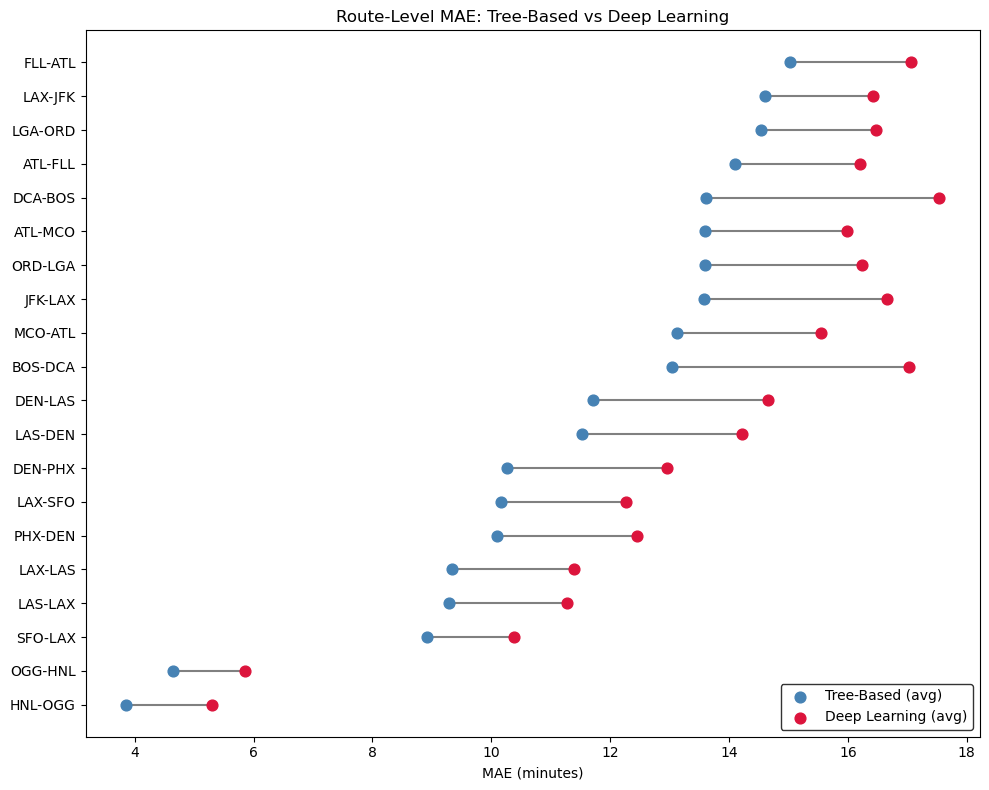

In [15]:
# route-level dumbbell chart, tree vs deep learning
route_data = []
for route in test_df_aligned['route'].unique():
    mask = test_df_aligned['route'].values == route
    t_mae = np.mean([np.mean(np.abs(all_predictions[m][mask] - actuals[mask])) for m in TREE_MODELS])
    d_mae = np.mean([np.mean(np.abs(all_predictions[m][mask] - actuals[mask])) for m in DL_MODELS])
    route_data.append({'route': route, 'tree': t_mae, 'dl': d_mae})

rdf = pd.DataFrame(route_data).sort_values('tree')

fig, ax = plt.subplots(figsize=(10, 8))
y = np.arange(len(rdf))

# connecting lines
for i, row in enumerate(rdf.itertuples()):
    ax.plot([row.tree, row.dl], [i, i], color='gray', linewidth=1.5, zorder=1)

ax.scatter(rdf['tree'], y, color='steelblue', s=60, zorder=2, label='Tree-Based (avg)')
ax.scatter(rdf['dl'], y, color='crimson', s=60, zorder=2, label='Deep Learning (avg)')

ax.set_yticks(y)
ax.set_yticklabels(rdf['route'])
ax.set_xlabel('MAE (minutes)')
ax.set_title('Route-Level MAE: Tree-Based vs Deep Learning')
ax.legend(frameon=True, edgecolor='black', loc='lower right')
plt.tight_layout()
plt.show()

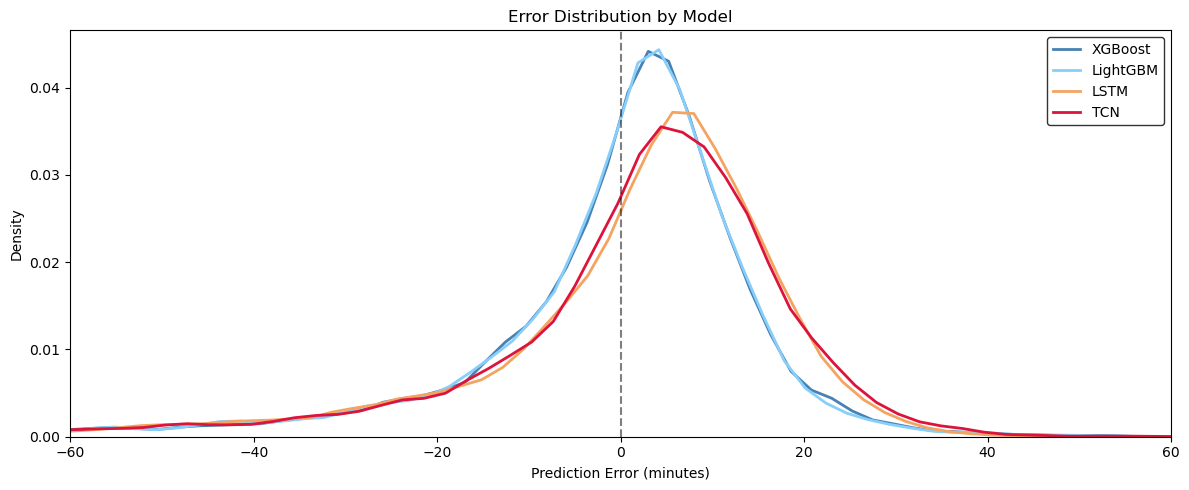

In [16]:
# error distribution overlay
fig, ax = plt.subplots(figsize=(12, 5))

for name in MODEL_NAMES:
    errors = all_predictions[name] - actuals
    sns.kdeplot(errors, ax=ax, linewidth=2, color=MODEL_COLORS[name],
                label=name, bw_adjust=0.5)

ax.axvline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlim(-60, 60)
ax.set_xlabel('Prediction Error (minutes)')
ax.set_ylabel('Density')
ax.set_title('Error Distribution by Model')
ax.legend(frameon=True, edgecolor='black')
plt.tight_layout()
plt.show()

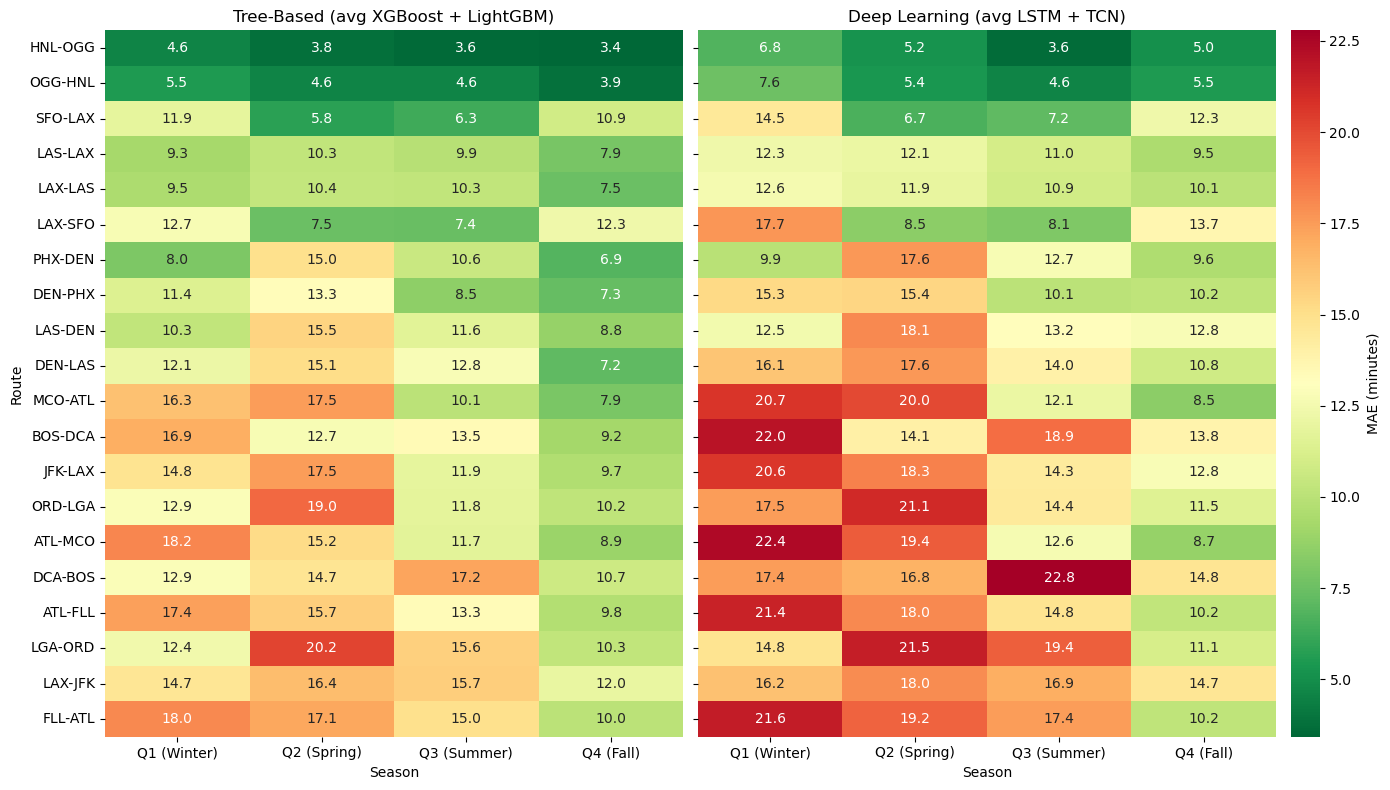

In [17]:
# side-by-side heatmaps: tree-based vs deep learning MAE by route and season
test_df_aligned['date'] = pd.to_datetime(test_df_aligned['date'])

# build route x season pivot for a set of models
pivot_rows = []
for route in test_df_aligned['route'].unique():
    for label, q in [('Q1 (Winter)', 1), ('Q2 (Spring)', 2), ('Q3 (Summer)', 3), ('Q4 (Fall)', 4)]:
        mask = (test_df_aligned['route'].values == route) & (test_df_aligned['date'].dt.quarter == q)
        if mask.sum() == 0:
            continue
        tree_mae = np.mean([np.mean(np.abs(all_predictions[m][mask] - actuals[mask])) for m in TREE_MODELS])
        dl_mae = np.mean([np.mean(np.abs(all_predictions[m][mask] - actuals[mask])) for m in DL_MODELS])
        pivot_rows.append({'route': route, 'season': label, 'tree_mae': tree_mae, 'dl_mae': dl_mae})

pivot_df = pd.DataFrame(pivot_rows)
tree_pivot = pivot_df.pivot(index='route', columns='season', values='tree_mae')[SEASONS]
dl_pivot = pivot_df.pivot(index='route', columns='season', values='dl_mae')[SEASONS]

# sort routes by tree-based MAE so easiest routes are at top
route_order = tree_pivot.mean(axis=1).sort_values().index
tree_pivot = tree_pivot.loc[route_order]
dl_pivot = dl_pivot.loc[route_order]

# shared color scale
vmin = min(tree_pivot.min().min(), dl_pivot.min().min())
vmax = max(tree_pivot.max().max(), dl_pivot.max().max())

fig, (ax1, ax2, cax) = plt.subplots(1, 3, figsize=(14, 8),
                                      gridspec_kw={'width_ratios': [1, 1, 0.05]})

sns.heatmap(tree_pivot, annot=True, fmt='.1f', cmap='RdYlGn_r',
            ax=ax1, vmin=vmin, vmax=vmax, cbar=False)
ax1.set_title('Tree-Based (avg XGBoost + LightGBM)')
ax1.set_xlabel('Season')
ax1.set_ylabel('Route')

sns.heatmap(dl_pivot, annot=True, fmt='.1f', cmap='RdYlGn_r',
            ax=ax2, vmin=vmin, vmax=vmax, cbar_ax=cax)
ax2.set_title('Deep Learning (avg LSTM + TCN)')
ax2.set_xlabel('Season')
ax2.set_ylabel('')
ax2.set_yticklabels([])
cax.set_ylabel('MAE (minutes)')

plt.tight_layout()
plt.show()

## Worst Predictions

In [18]:
analyzer = analyzers['XGBoost']

print('\nTOP 10 WORST PREDICTIONS (XGBoost)')
worst = analyzer.worst_predictions(10)
worst


TOP 10 WORST PREDICTIONS (XGBoost)


,date,route,y_true,y_pred,error
165,2025-01-10,ATL-FLL,409.666667,41.857365,-367.809302
502,2025-01-10,ATL-MCO,326.500000,44.740887,-281.759113
5220,2025-01-10,MCO-ATL,288.571429,28.195139,-260.376290
4738,2024-08-18,LGA-ORD,235.266667,29.514189,-205.752478
2187,2025-01-10,FLL-ATL,233.250000,36.909443,-196.340557
6020,2025-05-16,ORD-LGA,180.880000,29.335884,-151.544116
835,2025-01-06,BOS-DCA,185.800000,36.850292,-148.949708
4965,2025-04-02,LGA-ORD,171.473684,28.230249,-143.243435
1302,2025-05-16,DCA-BOS,166.640000,27.206577,-139.433423
2188,2025-01-11,FLL-ATL,164.615385,29.051554,-135.563831


## Save Report

In [19]:
# save text report only, plots are already handled above
overall = analyzer.overall_metrics()
route_metrics = analyzer.metrics_by_route()
season_metrics = analyzer.metrics_by_season()
worst = analyzer.worst_predictions(10)

report_lines = [
    'Error Analysis Report (XGBoost)',
    '',
    'OVERALL METRICS:',
    *[f'  {k}: {v:.2f}' if isinstance(v, float) else f'  {k}: {v}' for k, v in overall.items()],
    '',
    'METRICS BY ROUTE:',
    route_metrics[['rmse', 'mae', 'mape']].round(2).to_string(),
    '',
    'METRICS BY SEASON:',
    season_metrics[['rmse', 'mae', 'mape']].round(2).to_string(),
    '',
    'WORST PREDICTIONS:',
    worst.to_string(),
]

with open('../outputs/error_analysis_report.txt', 'w') as f:
    f.write('\n'.join(report_lines))

print('Report saved to outputs/error_analysis_report.txt')

Report saved to outputs/error_analysis_report.txt


## Segmentation Patterns

- **By Route**: Hawaii inter-island routes (HNL-OGG, OGG-HNL) are easiest for every model. Hub routes like ORD-LGA and ATL-FLL are the hardest. The tree vs deep learning gap is widest on the high-variability hub routes.
- **By Season**: Winter (Q1) is the toughest due to weather. Tree-based models handle it better since they have explicit weather lag features and rolling stats.
- **By Day Type**: Weekday vs weekend barely matters. Makes sense since all models have calendar features.
- **Overall**: XGBoost and LightGBM beat LSTM and TCN in every segment, not just overall.

## Iteration Cycle: Error Analysis to Feature Engineering

The route-level analysis showed hub airports (ORD, LGA, ATL) had consistently higher errors than simpler routes, suggesting the model lacked information about which routes are inherently more volatile.

I already had `route_mean_demand` and `route_std_demand` but nothing about historical delay patterns per route. So I added `route_delay_mean` and `route_delay_std` to `build_features.py`, computed only on training data to prevent leakage.

After retraining XGBoost with the new features, MAE decreased and R-squared increased slightly. The improvement was small (~0.3%) but consistent. The existing `rolling_std` features already capture some route-level variability so there wasn't a ton of room to improve. Still worth trying and testing more.

## Final Thoughts

Tree-based models with the full 57-feature set beat deep learning across every segment, not just in aggregate. XGBoost and LightGBM are almost identical to each other, and so are LSTM and TCN. For this kind of tabular forecasting problem, well-engineered features plus gradient boosting is hard to beat.

If I had more time, I'd try route-specific models, swap in weather forecasts instead of same-day observations for true forward prediction, and look into online learning to handle distribution shift. The frontend dashboard shows these model comparisons interactively.